In [2]:
pip install opencv-python numpy matplotlib seaborn scikit-learn tensorflow ipython


  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   - -------------------------------------- 1.6/39.5 MB 7.6 MB/s eta 0:00:05
   -- ------------------------------------- 2.9/39.5 MB 6.7 MB/s eta 0:00:06
   --- ------------------------------------ 3.9/39.5 MB 6.5 MB/s eta 0:00:06
   ----- ---------------------------------- 5.0/39.5 MB 5.9 MB/s eta 0:00:06
   ----- ---------------------------------- 5.8/39.5 MB 5.8 MB/s eta 0:00:06
   ------ --------------------------------- 6.8/39.5 MB 5.5 MB/s eta 0:00:06
   ------- -------------------------------- 7.9/39.5 MB 5.5 MB/s eta 0:00:06
   --------- ------------------------------ 9.2/39.5 MB 5.5 MB/s eta 0:00:06
   ---------- ----------------------------- 10.2/39.5 MB 5.5 MB/s eta 0:00:06
   ----------- ---------------------------- 11.5/39.5 MB 5.6 MB/s eta 0:00:06
   ------------- -------------------------- 12.8/39.5 MB 5.6 MB/s eta 0:00:05


In [3]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from tensorflow import keras
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from IPython.display import HTML
from base64 import b64encode

In [5]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [6]:
import kagglehub
mohamedmustafa_real_life_violence_situations_dataset_path = kagglehub.dataset_download('mohamedmustafa/real-life-violence-situations-dataset')

print('Data source import complete.')
print("Path to dataset files:", mohamedmustafa_real_life_violence_situations_dataset_path)


100%|█████████████████████████████████████████████████████████████████████████████| 3.58G/3.58G [11:24<00:00, 5.62MB/s]

Extracting files...


Data source import complete.
Path to dataset files: C:\Users\EDUARDO\.cache\kagglehub\datasets\mohamedmustafa\real-life-violence-situations-dataset\versions\1


In [90]:
BATCH_SIZE = 16 

# Rutas del dataset
DATASET_DIR = "C:/Users/EDUARDO/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1"
CLASSES_LIST = ["NonViolence", "Violence"]

print("Configuración inicial completada")

Configuración inicial completada


**EXPLORAR Y VISUALIZAR EL DATASET**

In [91]:
# Ruta base del dataset
base_path = "C:/Users/EDUARDO/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1"

# Recorrer los directorios y archivos
for root, dirs, files in os.walk(base_path):
    print(f"Directorio: {root}")
    for name in dirs:
        print(f"  Subdirectorio: {name}")
    for name in files:
        print(f"  Archivo: {name}")


Directorio: C:/Users/EDUARDO/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1
  Subdirectorio: Real Life Violence Dataset
  Subdirectorio: real life violence situations
Directorio: C:/Users/EDUARDO/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1\Real Life Violence Dataset
  Subdirectorio: NonViolence
  Subdirectorio: Violence
Directorio: C:/Users/EDUARDO/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1\Real Life Violence Dataset\NonViolence
  Archivo: NV_1.mp4
  Archivo: NV_10.mp4
  Archivo: NV_100.mp4
  Archivo: NV_1000.mp4
  Archivo: NV_101.mp4
  Archivo: NV_102.mp4
  Archivo: NV_103.mp4
  Archivo: NV_104.mp4
  Archivo: NV_105.mp4
  Archivo: NV_106.mp4
  Archivo: NV_107.mp4
  Archivo: NV_108.mp4
  Archivo: NV_109.mp4
  Archivo: NV_11.mp4
  Archivo: NV_110.mp4
  Archivo: NV_111.mp4
  Archivo: NV_112.mp4
  Archivo: NV_113.mp4
  Archivo: NV_114.mp4
  Archivo: NV_11

In [92]:
from IPython.display import HTML
from base64 import b64encode

def Play_Video(filepath):
    html = ''
    video = open(filepath,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

In [93]:
NonViolnceVideos_Dir = "C:/Users/EDUARDO/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1/real life violence situations/Real Life Violence Dataset/NonViolence"
ViolnceVideos_Dir = "C:/Users/EDUARDO/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1/real life violence situations/Real Life Violence Dataset/Violence"

# Retrieve the list of all the video files present in the Class Directory.
NonViolence_files_names_list = os.listdir(NonViolnceVideos_Dir)
Violence_files_names_list = os.listdir(ViolnceVideos_Dir)

# Randomly select a video file from the Classes Directory.
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)

In [94]:
Random_NonViolence_Video

'NV_567.mp4'

In [95]:
Random_Violence_Video

'V_491.mp4'

In [96]:
Play_Video(f"{NonViolnceVideos_Dir}/{Random_NonViolence_Video}")

In [97]:
Play_Video(f"{ViolnceVideos_Dir}/{Random_Violence_Video}")

***Configuración y extracción de frames***

In [98]:
IMAGE_HEIGHT, IMAGE_WIDTH = 48, 48 

SEQUENCE_LENGTH = 10 

DATASET_DIR = "C:/Users/EDUARDO/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1/real life violence situations/Real Life Violence Dataset/"
CLASSES_LIST = ["NonViolence","Violence"]

In [99]:
def frames_extraction(video_path, augment=False):
    frames_list = []
    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        # Reading the frame from the video.
        success, frame = video_reader.read()
        if not success:
            break
            
        # Aplicar data augmentation si se especifica
        if augment and random.random() > 0.5:
            # Rotación aleatoria (leve)
            if random.random() > 0.7:
                rows, cols, _ = frame.shape
                M = cv2.getRotationMatrix2D((cols/2, rows/2), random.uniform(-15, 15), 1)
                frame = cv2.warpAffine(frame, M, (cols, rows))
            
            # Ajustes de brillo/contraste
            if random.random() > 0.7:
                alpha = 1.0 + random.uniform(-0.3, 0.3)  # Contraste
                beta = random.uniform(-30, 30)  # Brillo
                frame = cv2.convertScaleAbs(frame, alpha=alpha, beta=beta)
                
            # Flip horizontal
            if random.random() > 0.7:
                frame = cv2.flip(frame, 1)
        
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # Normalize the resized frame
        normalized_frame = resized_frame / 255
        # Append the normalized frame into the frames list - forzando float32
        frames_list.append(normalized_frame.astype(np.float32))
        
    video_reader.release()
    
    # Si no se consiguieron suficientes frames, completar la secuencia
    while len(frames_list) < SEQUENCE_LENGTH:
        # Usar el último frame disponible o un frame negro si no hay ninguno
        last_frame = frames_list[-1] if frames_list else np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=np.float32)
        frames_list.append(last_frame)
        
    return frames_list


In [100]:
def create_dataset(augment=True, augment_factor=1.2):  # Reducimos el factor de aumentación
    features = []
    labels = []
    video_files_paths = []
    
    # Calcular distribución de clases para identificar clase minoritaria
    class_counts = {}
    for class_name in CLASSES_LIST:
        class_counts[class_name] = len(os.listdir(os.path.join(DATASET_DIR, class_name)))
    
    min_class = min(class_counts, key=class_counts.get)
    print(f"Distribución original: {class_counts}")
    
    # Iterating through all the classes.
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Determinar si aplicar augmentation según si es clase minoritaria
        apply_augment = augment and (class_name == min_class)
        augment_count = int(len(files_list) * (augment_factor - 1)) if apply_augment else 0
        
        if apply_augment:
            print(f"  Aplicando data augmentation: {augment_count} videos adicionales")
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            
            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path, augment=False)
            
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified.
            if len(frames) == SEQUENCE_LENGTH:
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
                
                # Añadir versiones aumentadas para la clase minoritaria
                if apply_augment and augment_count > 0:
                    aug_frames = frames_extraction(video_file_path, augment=True)
                    features.append(aug_frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path + "_augmented")
                    augment_count -= 1
    
    # Especificar explícitamente float32 para ahorrar memoria
    features = np.asarray(features, dtype=np.float32)
    labels = np.array(labels)
    
    # Mostrar estadísticas finales
    print(f"Dataset final: {features.shape}, Tipo: {features.dtype}")
    print(f"Tamaño en memoria: {features.nbytes / (1024**3):.2f} GB")
    
    unique, counts = np.unique(labels, return_counts=True)
    for i, (u, c) in enumerate(zip(unique, counts)):
        print(f"Clase {CLASSES_LIST[u]}: {c} muestras ({c/len(labels)*100:.1f}%)")
    
    return features, labels, video_files_paths

In [101]:
# Create the dataset with data augmentation
features, labels, video_files_paths = create_dataset(augment=True)


Distribución original: {'NonViolence': 1000, 'Violence': 1000}
Extracting Data of Class: NonViolence
  Aplicando data augmentation: 199 videos adicionales
Extracting Data of Class: Violence
Dataset final: (2199, 10, 48, 48, 3), Tipo: float32
Tamaño en memoria: 0.57 GB
Clase NonViolence: 1199 muestras (54.5%)
Clase Violence: 1000 muestras (45.5%)


In [142]:
np.save("data/features.npy", features)
np.save("labels.npy", labels)
np.save("video_files_paths.npy", video_files_paths)

In [103]:
features, labels, video_files_paths = np.load("features.npy") , np.load("labels.npy") ,  np.load("video_files_paths.npy")

*Codificación y división de conjuntos de entrenamiento y prueba*

In [104]:
# convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [105]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, 
    one_hot_encoded_labels, 
    test_size=0.15, 
    shuffle=True, 
    random_state=42,
    stratify=labels 
)

In [106]:
# Información sobre los conjuntos de datos
print(f"Conjunto de entrenamiento: {features_train.shape}, {labels_train.shape}")
print(f"Conjunto de prueba: {features_test.shape}, {labels_test.shape}")

Conjunto de entrenamiento: (1869, 10, 48, 48, 3), (1869, 2)
Conjunto de prueba: (330, 10, 48, 48, 3), (330, 2)


In [107]:
# Verificar distribución de clases
train_class_distribution = np.sum(labels_train, axis=0)
test_class_distribution = np.sum(labels_test, axis=0)

print("\nDistribución de clases:")
for i, class_name in enumerate(CLASSES_LIST):
    print(f"{class_name}: {train_class_distribution[i]} en train ({train_class_distribution[i]/len(labels_train)*100:.1f}%), "
          f"{test_class_distribution[i]} en test ({test_class_distribution[i]/len(labels_test)*100:.1f}%)")


Distribución de clases:
NonViolence: 1019.0 en train (54.5%), 180.0 en test (54.5%)
Violence: 850.0 en train (45.5%), 150.0 en test (45.5%)


**Importing MobileNet and Fine-Tuning it**

In [108]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Cargar MobileNetV2 con la forma de entrada correcta
mobilenet = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)  # Especificar dimensiones de entrada
)

# Fine-Tuning con más capas descongeladas (50 en lugar de 40)
mobilenet.trainable = True
for layer in mobilenet.layers[:-50]:  # Aumentamos de 40 a 50 capas descongeladas
    layer.trainable = False

# Contar parámetros entrenables y no entrenables
trainable_params = sum([tf.keras.backend.count_params(w) for w in mobilenet.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in mobilenet.non_trainable_weights])

print(f"MobileNetV2 configurado con input_shape={IMAGE_HEIGHT}x{IMAGE_WIDTH}x3")
print(f"Parámetros entrenables: {trainable_params:,}")
print(f"Parámetros no entrenables: {non_trainable_params:,}")
print(f"Total parámetros: {trainable_params + non_trainable_params:,}")
print(f"Proporción de parámetros entrenables: {trainable_params/(trainable_params + non_trainable_params)*100:.1f}%")

C:\Users\EDUARDO\AppData\Local\Temp\ipykernel_7712\1111485504.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
MobileNetV2 configurado con input_shape=48x48x3
Parámetros entrenables: 1,855,104
Parámetros no entrenables: 402,880
Total parámetros: 2,257,984
Proporción de parámetros entrenables: 82.2%


In [109]:
def create_model():
    model = Sequential(name="Violence_Detection_MoBiLSTM")
    
    # Entrada
    model.add(Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3), name="input_layer"))
    
    # Extracción de características con MobileNetV2
    model.add(TimeDistributed(mobilenet, name="mobilenetv2_feature_extractor"))
    
    # Global Average Pooling en lugar de Flatten para reducir parámetros
    model.add(TimeDistributed(GlobalAveragePooling2D(), name="global_avg_pooling"))
    model.add(Dropout(0.3, name="dropout_1"))
    
    # BiLSTM mejorado con más unidades
    model.add(Bidirectional(LSTM(units=128, return_sequences=True), name="bidirectional_lstm"))
    model.add(Dropout(0.3, name="dropout_2"))
    
    # Segundo LSTM para capturar dependencias temporales más complejas
    model.add(LSTM(units=128, name="lstm_layer"))
    model.add(Dropout(0.3, name="dropout_3"))
    
    # Capas densas con normalización y dropout variable
    model.add(Dense(256, activation='relu', name="dense_1"))
    model.add(BatchNormalization(name="batch_norm_1"))
    model.add(Dropout(0.4, name="dropout_4"))  # Mayor dropout en las primeras capas densas
    
    model.add(Dense(128, activation='relu', name="dense_2"))
    model.add(BatchNormalization(name="batch_norm_2"))
    model.add(Dropout(0.3, name="dropout_5"))
    
    model.add(Dense(64, activation='relu', name="dense_3"))
    model.add(BatchNormalization(name="batch_norm_3"))
    model.add(Dropout(0.25, name="dropout_6"))
    
    # Capa de salida
    model.add(Dense(len(CLASSES_LIST), activation='softmax', name="output_layer"))
    
    # Mostrar resumen
    model.summary()
    
    return model

In [110]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [111]:
pip install graphviz

In [112]:
from tensorflow.keras.utils import plot_model

In [113]:
MoBiLSTM_model = create_model()

# Plot the structure of the contructed LRCN model.
plot_model(MoBiLSTM_model, to_file = 'MobBiLSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

Model: "Violence_Detection_MoBiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_feature_extractor        │ (None, 10, 2, 2, 1280)      │       2,257,984 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_avg_pooling (TimeDistributed) │ (None, 10, 1280)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 1280)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_lstm (Bidirectional)   │ (None, 10, 256)             │       1,442,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer (LSTM)                    │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_norm_1 (BatchNormalization)    │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_norm_2 (BatchNormalization)    │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_norm_3 (BatchNormalization)    │ (None, 64)                  │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,974,018 (15.16 MB)

 Trainable params: 3,570,242 (13.62 MB)

 Non-trainable params: 403,776 (1.54 MB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [71]:
try:
    plot_model(MoBiLSTM_model, to_file='improved_model_structure_plot.png', show_shapes=True, show_layer_names=True)
    print("Estructura del modelo guardada en 'improved_model_structure_plot.png'")
except:
    print("No se pudo guardar la estructura del modelo. Verifica que pydot y graphviz estén instalados.")

You must install pydot (`pip install pydot`) for `plot_model` to work.
Estructura del modelo guardada en 'improved_model_structure_plot.png'


In [114]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import numpy as np

class VideoDataGenerator(Sequence):
    """Generador de datos para cargar videos por lotes para evitar problemas de memoria"""
    
    def __init__(self, features, labels, batch_size=8, shuffle=True):
        self.features = features
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(features))
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __len__(self):
        """Denota el número de batches por época"""
        return int(np.ceil(len(self.features) / self.batch_size))
    
    def __getitem__(self, index):
        """Genera un batch de datos"""
        # Seleccionar índices para este batch
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Extraer datos
        batch_x = self.features[batch_indices]
        batch_y = self.labels[batch_indices]
        
        return batch_x, batch_y
    
    def on_epoch_end(self):
        """Acciones al final de cada época"""
        if self.shuffle:
            np.random.shuffle(self.indices)

# Crear generadores para entrenamiento y validación
validation_split = 0.2
split_idx = int(len(features_train) * (1 - validation_split))

# Mezclar los índices
indices = np.arange(len(features_train))
np.random.shuffle(indices)
train_idx, val_idx = indices[:split_idx], indices[split_idx:]

# Crear los generadores
train_generator = VideoDataGenerator(
    features_train[train_idx], 
    labels_train[train_idx], 
    batch_size=8,
    shuffle=True
)

val_generator = VideoDataGenerator(
    features_train[val_idx], 
    labels_train[val_idx], 
    batch_size=8,
    shuffle=False
)

# Callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.6,
    patience=5,
    min_lr=0.00005,
    verbose=1
)

# Compilar el modelo
MoBiLSTM_model.compile(
    loss='categorical_crossentropy', 
    optimizer='sgd',  # Mantenemos SGD como en tu versión original
    metrics=["accuracy"]
)

# Entrenar el modelo usando generadores
MobBiLSTM_model_history = MoBiLSTM_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping_callback, reduce_lr],
    verbose=1
)

# Guardar el modelo final
MoBiLSTM_model.save('violence_detection_model.h5')

Epoch 1/50


C:\Users\EDUARDO\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


187/187 ━━━━━━━━━━━━━━━━━━━━ 177s 548ms/step - accuracy: 0.5149 - loss: 0.9982 - val_accuracy: 0.5080 - val_loss: 0.7088 - learning_rate: 0.0100
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 83s 443ms/step - accuracy: 0.5558 - loss: 0.7528 - val_accuracy: 0.6390 - val_loss: 0.6377 - learning_rate: 0.0100
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 80s 427ms/step - accuracy: 0.5706 - loss: 0.6914 - val_accuracy: 0.6872 - val_loss: 0.5522 - learning_rate: 0.0100
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 78s 420ms/step - accuracy: 0.7136 - loss: 0.5764 - val_accuracy: 0.8155 - val_loss: 0.4251 - learning_rate: 0.0100
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 77s 414ms/step - accuracy: 0.7148 - loss: 0.5467 - val_accuracy: 0.8289 - val_loss: 0.4057 - learning_rate: 0.0100
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 76s 407ms/step - accuracy: 0.7546 - loss: 0.4843 - val_accuracy: 0.8583 - val_loss: 0.3620 - learning_rate: 0.0100
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 76s 408ms/step - accuracy: 0.8200 - loss

In [115]:
MoBiLSTM_model.save('violence_detection_model.keras')

In [116]:
model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 423ms/step - accuracy: 0.9084 - loss: 0.2389


In [117]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Get the Epochs Count
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

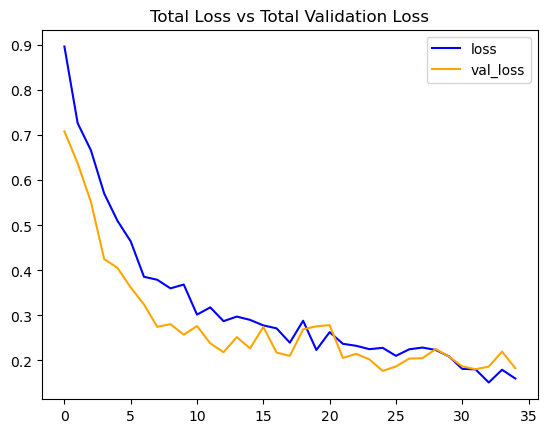

In [118]:
plot_metric(MobBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

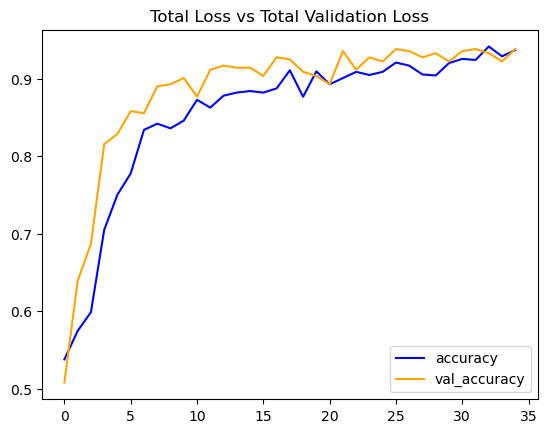

In [119]:
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

*Predicting the Test Set*

In [120]:
labels_predict = MoBiLSTM_model.predict(features_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step 


In [121]:
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [122]:
labels_test_normal.shape , labels_predict.shape

((330,), (330,))

In [123]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.9242424242424242


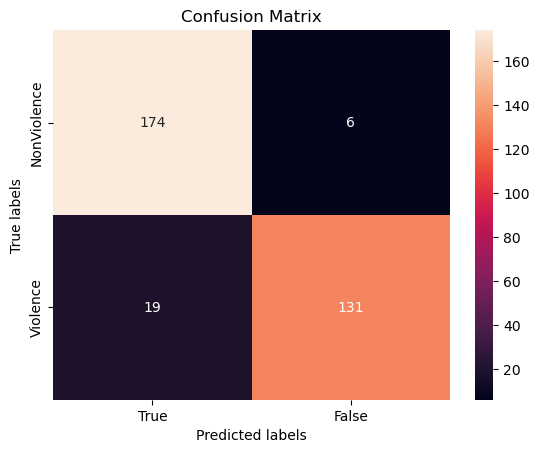

In [124]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['True', 'False']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

In [125]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       180
           1       0.96      0.87      0.91       150

    accuracy                           0.92       330
   macro avg       0.93      0.92      0.92       330
weighted avg       0.93      0.92      0.92       330



**Evaluar el modelo en el conjunto de prueba**

In [126]:
# Evaluación en el conjunto de prueba
model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test, verbose=1)
print(f"Pérdida en test: {model_evaluation_history[0]:.4f}")
print(f"Precisión en test: {model_evaluation_history[1]:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 361ms/step - accuracy: 0.9084 - loss: 0.2389
Pérdida en test: 0.2092
Precisión en test: 0.9242


In [127]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Generar predicciones
y_pred = MoBiLSTM_model.predict(features_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(labels_test, axis=1)

# Calcular métricas
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print("\nMétricas detalladas:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Reporte de clasificación completo
print("\nReporte de clasificación completo:")
print(classification_report(y_true, y_pred_classes, target_names=CLASSES_LIST))

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 366ms/step

Métricas detalladas:
Accuracy: 0.9242
Precision: 0.9264
Recall: 0.9242
F1-score: 0.9238

Reporte de clasificación completo:
              precision    recall  f1-score   support

 NonViolence       0.90      0.97      0.93       180
    Violence       0.96      0.87      0.91       150

    accuracy                           0.92       330
   macro avg       0.93      0.92      0.92       330
weighted avg       0.93      0.92      0.92       330



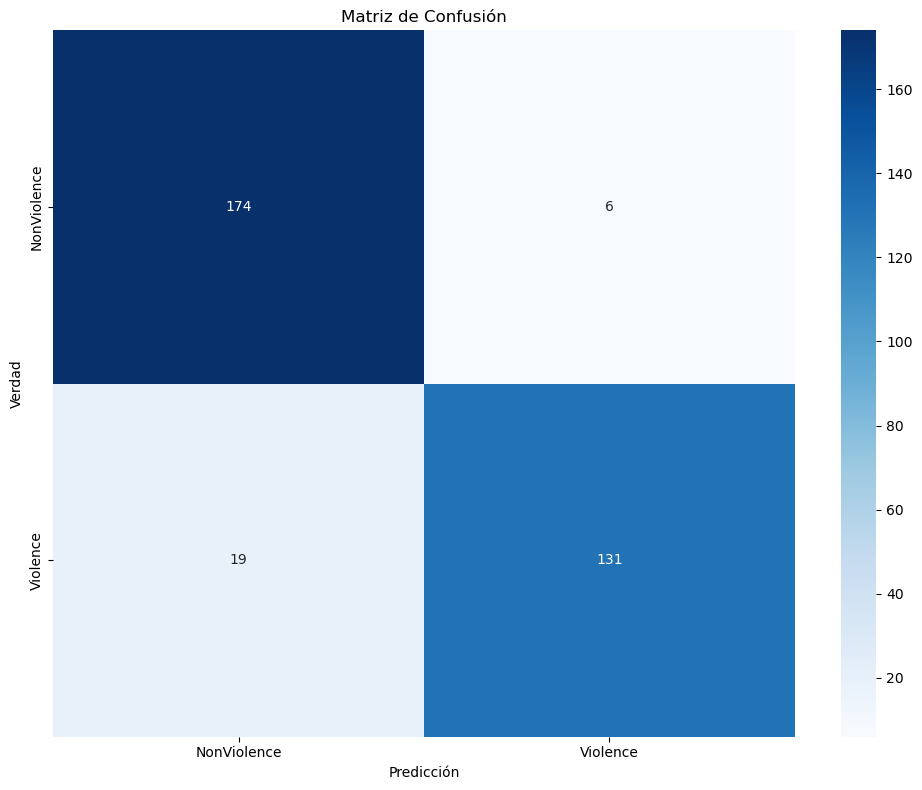

Verdaderos Negativos (No Violencia correctamente identificada): 174
Falsos Positivos (No Violencia clasificada incorrectamente como Violencia): 6
Falsos Negativos (Violencia clasificada incorrectamente como No Violencia): 19
Verdaderos Positivos (Violencia correctamente identificada): 131

Tasa de detección de violencia (Sensibilidad/Recall): 0.8733
Tasa de falsa alarma: 0.0333


In [128]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)

# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
plt.xlabel('Predicción')
plt.ylabel('Verdad')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()

# Calcular tasas específicas
tn, fp, fn, tp = cm.ravel()
print(f"Verdaderos Negativos (No Violencia correctamente identificada): {tn}")
print(f"Falsos Positivos (No Violencia clasificada incorrectamente como Violencia): {fp}")
print(f"Falsos Negativos (Violencia clasificada incorrectamente como No Violencia): {fn}")
print(f"Verdaderos Positivos (Violencia correctamente identificada): {tp}")

# Calcular métricas específicas del contexto
print(f"\nTasa de detección de violencia (Sensibilidad/Recall): {tp/(tp+fn):.4f}")
print(f"Tasa de falsa alarma: {fp/(fp+tn):.4f}")

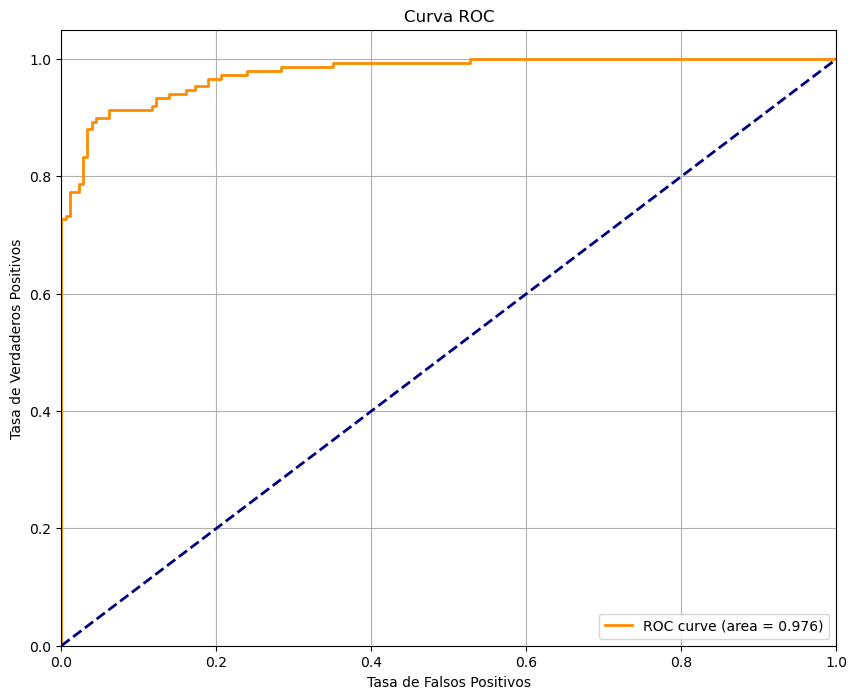

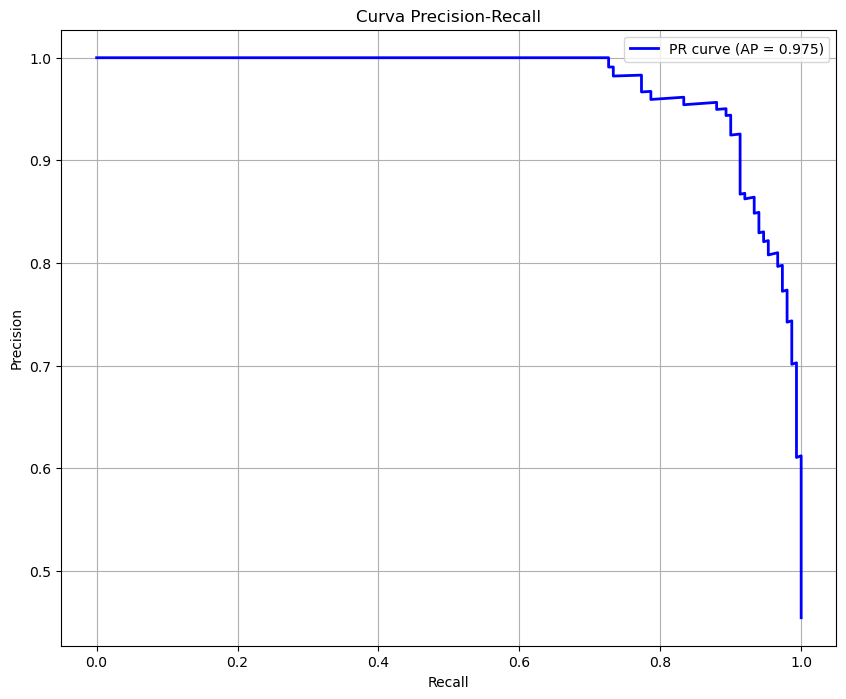

In [129]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])  # Asumiendo que la clase 1 es "Violence"
roc_auc = auc(fpr, tpr)

# Dibujar curva ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Calcular curva precision-recall
precision, recall, _ = precision_recall_curve(y_true, y_pred[:, 1])
avg_precision = average_precision_score(y_true, y_pred[:, 1])

# Dibujar curva precision-recall
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

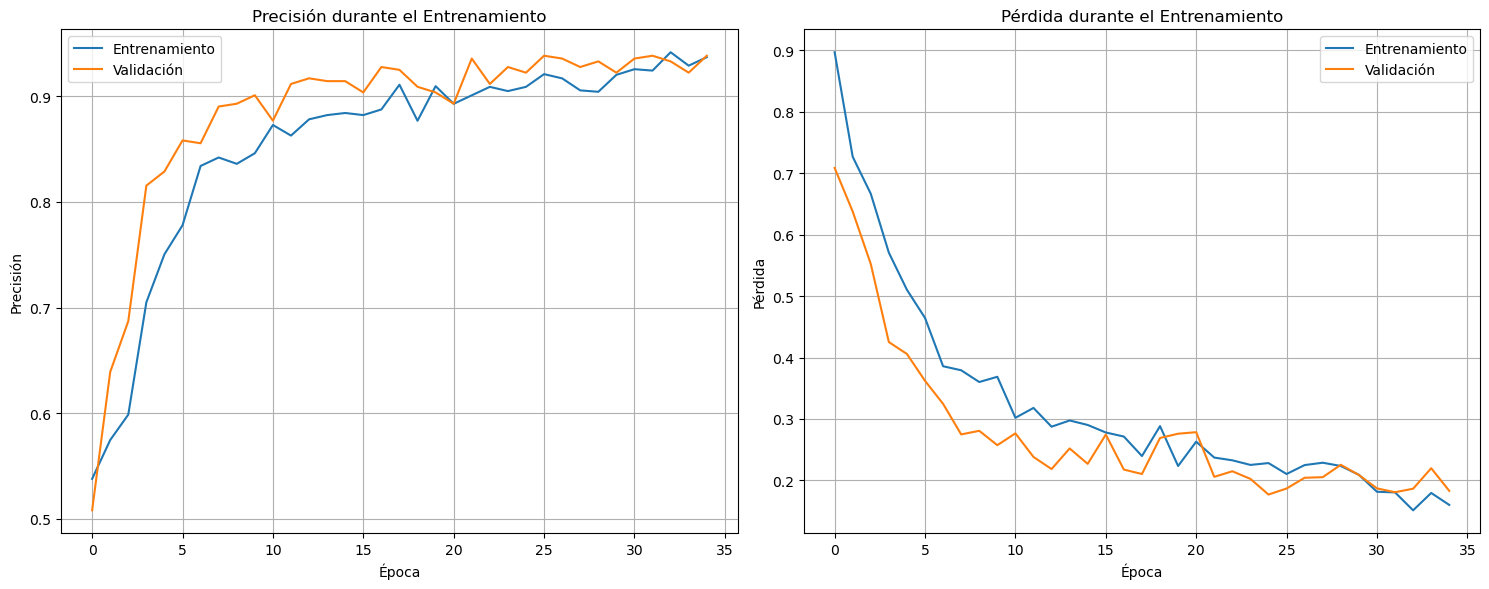

In [130]:
def plot_learning_curves(history):
    """Visualiza las curvas de aprendizaje del modelo"""
    plt.figure(figsize=(15, 6))
    
    # Graficar precisión
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Precisión durante el Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()
    plt.grid(True)
    
    # Graficar pérdida
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Pérdida durante el Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Visualizar curvas de aprendizaje
plot_learning_curves(MobBiLSTM_model_history)

In [132]:
def predict_on_video(video_path, output_path=None, confidence_threshold=0.6):
    """
    Realiza predicciones en un video y opcionalmente guarda el resultado
    
    Args:
        video_path: Ruta al video de entrada
        output_path: Ruta donde guardar el video procesado (opcional)
        confidence_threshold: Umbral de confianza para detectar violencia
    """
    # Leer el video
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: No se pudo abrir el video {video_path}")
        return
    
    # Obtener propiedades del video
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video: {video_path}")
    print(f"Dimensiones: {width}x{height}, FPS: {fps}, Frames: {frame_count}")
    
    # Configurar writer si se especifica output_path
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Cola para almacenar frames
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    
    # Inicializar con frames vacíos
    for _ in range(SEQUENCE_LENGTH):
        frames_queue.append(np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=np.float32))
    
    # Variables para estadísticas
    frame_count = 0
    violence_detected_frames = 0
    detection_confidence = []
    
    # Procesar el video
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        
        # Preprocesar frame
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0
        
        # Actualizar cola
        frames_queue.append(normalized_frame)
        
        # Realizar predicción cada SEQUENCE_LENGTH/2 frames o en el primer frame
        if frame_count % (SEQUENCE_LENGTH//2) == 0 or frame_count == 1:
            # Convertir cola a array numpy
            input_frames = np.array(list(frames_queue))
            input_frames = np.expand_dims(input_frames, axis=0)
            
            # Hacer predicción
            prediction = MoBiLSTM_model.predict(input_frames, verbose=0)[0]
            
            # Obtener clase y confianza
            predicted_class_idx = np.argmax(prediction)
            confidence = prediction[predicted_class_idx]
            predicted_class = CLASSES_LIST[predicted_class_idx]
            
            detection_confidence.append(confidence)
            
            # Verificar si se detecta violencia
            is_violence = (predicted_class == "Violence" and confidence >= confidence_threshold)
            if is_violence:
                violence_detected_frames += 1
        
        # Añadir información al frame si se guarda output
        if output_path:
            if predicted_class == "Violence" and confidence >= confidence_threshold:
                color = (0, 0, 255)  # Rojo para violencia
                cv2.putText(frame, f"VIOLENCIA: {confidence:.2f}", (10, 50), 
                          cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
                cv2.rectangle(frame, (0, 0), (width, height), color, 5)
            else:
                color = (0, 255, 0)  # Verde para no violencia
                cv2.putText(frame, f"NO VIOLENCIA: {confidence:.2f}", (10, 50), 
                          cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            
            # Guardar frame
            out.write(frame)
    
    # Liberar recursos
    cap.release()
    if output_path:
        out.release()
    
    # Calcular estadísticas
    violence_percentage = (violence_detected_frames / frame_count) * 100
    avg_confidence = np.mean(detection_confidence) if detection_confidence else 0
    
    print(f"\nResultados del análisis:")
    print(f"Porcentaje de frames con violencia detectada: {violence_percentage:.2f}%")
    print(f"Confianza promedio: {avg_confidence:.4f}")
    
    if violence_percentage > 30:  # Umbral arbitrario, ajustar según necesidades
        print("Resultado: SE DETECTÓ VIOLENCIA SIGNIFICATIVA EN EL VIDEO")
    else:
        print("Resultado: NO SE DETECTÓ VIOLENCIA SIGNIFICATIVA EN EL VIDEO")
    
    return violence_percentage, avg_confidence

# Probar con videos de prueba
test_videos = [
    "C:/Users/EDUARDO/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1/real life violence situations/Real Life Violence Dataset/Violence/V_12.mp4",
    "C:/Users/EDUARDO/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1/real life violence situations/Real Life Violence Dataset/NonViolence/NV_1.mp4"
]

# Crear directorio para videos procesados
os.makedirs("processed_videos", exist_ok=True)

# Procesar cada video
for i, video_path in enumerate(test_videos):
    print(f"\nAnalizando video {i+1}/{len(test_videos)}")
    output_path = f"processed_videos/processed_video_{i+1}.mp4"
    predict_on_video(video_path, output_path)


Analizando video 1/2
Video: C:/Users/EDUARDO/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1/real life violence situations/Real Life Violence Dataset/Violence/V_12.mp4
Dimensiones: 410x652, FPS: 29.97002997002997, Frames: 138

Resultados del análisis:
Porcentaje de frames con violencia detectada: 11.59%
Confianza promedio: 0.7765
Resultado: NO SE DETECTÓ VIOLENCIA SIGNIFICATIVA EN EL VIDEO

Analizando video 2/2
Video: C:/Users/EDUARDO/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1/real life violence situations/Real Life Violence Dataset/NonViolence/NV_1.mp4
Dimensiones: 1920x1080, FPS: 24.900440159295744, Frames: 66

Resultados del análisis:
Porcentaje de frames con violencia detectada: 0.00%
Confianza promedio: 0.9916
Resultado: NO SE DETECTÓ VIOLENCIA SIGNIFICATIVA EN EL VIDEO


In [135]:
test_videos = [
    "C:/Users/EDUARDO/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1/real life violence situations/Real Life Violence Dataset/Violence/V_440.mp4",
    "C:/Users/EDUARDO/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1/real life violence situations/Real Life Violence Dataset/NonViolence/NV_100.mp4"
]

# Crear directorio para videos procesados
os.makedirs("processed_videos", exist_ok=True)

# Procesar cada video
for i, video_path in enumerate(test_videos):
    print(f"\nAnalizando video {i+1}/{len(test_videos)}")
    output_path = f"processed_videos/processed_video_{i+1}.mp4"
    predict_on_video(video_path, output_path)


Analizando video 1/2
Video: C:/Users/EDUARDO/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1/real life violence situations/Real Life Violence Dataset/Violence/V_440.mp4
Dimensiones: 1280x720, FPS: 30.0, Frames: 120

Resultados del análisis:
Porcentaje de frames con violencia detectada: 20.00%
Confianza promedio: 0.9498
Resultado: NO SE DETECTÓ VIOLENCIA SIGNIFICATIVA EN EL VIDEO

Analizando video 2/2
Video: C:/Users/EDUARDO/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1/real life violence situations/Real Life Violence Dataset/NonViolence/NV_100.mp4
Dimensiones: 224x224, FPS: 30.0, Frames: 150

Resultados del análisis:
Porcentaje de frames con violencia detectada: 0.00%
Confianza promedio: 0.9920
Resultado: NO SE DETECTÓ VIOLENCIA SIGNIFICATIVA EN EL VIDEO


In [139]:
import cv2
import numpy as np
from collections import deque
import time
import tensorflow as tf

def detect_violence_webcam(model, threshold=0.6, camera_id=0):
    """
    Detecta violencia en tiempo real usando la webcam
    
    Args:
        model: El modelo entrenado
        threshold: Umbral de confianza para detectar violencia
        camera_id: ID de la cámara a utilizar (0 para la webcam predeterminada)
    """
    # Inicializar la webcam
    cap = cv2.VideoCapture(camera_id)
    
    if not cap.isOpened():
        print("Error: No se pudo abrir la webcam.")
        return
    
    # Ajustar la resolución para mejor rendimiento
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    
    # Cola para almacenar frames
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    
    # Inicializar con frames vacíos
    for _ in range(SEQUENCE_LENGTH):
        frames_queue.append(np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=np.float32))
    
    # Variables para medición de rendimiento
    frame_count = 0
    prediction_count = 0
    start_time = time.time()
    fps_list = []
    
    # Variables para la predicción
    predicted_class = "Iniciando..."
    confidence = 0.0
    
    print("Iniciando detección en tiempo real. Presiona 'q' para salir.")
    
    while True:
        # Medir tiempo para cálculo de FPS
        frame_start_time = time.time()
        
        # Leer frame de la webcam
        ret, frame = cap.read()
        if not ret:
            print("Error al leer frame de la webcam.")
            break
        
        # Incrementar contador
        frame_count += 1
        
        # Preprocesar frame
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0
        
        # Actualizar cola
        frames_queue.append(normalized_frame)
        
        # Realizar predicción cada cierto número de frames para mantener buen rendimiento
        if frame_count % 5 == 0:  # Predecir cada 5 frames
            prediction_count += 1
            prediction_start = time.time()
            
            # Preparar datos de entrada
            input_data = np.expand_dims(np.array(list(frames_queue)), axis=0)
            
            # Realizar predicción
            prediction = model.predict(input_data, verbose=0)[0]
            
            # Obtener clase y confianza
            predicted_idx = np.argmax(prediction)
            confidence = prediction[predicted_idx]
            predicted_class = CLASSES_LIST[predicted_idx]
            
            prediction_time = time.time() - prediction_start
        
        # Añadir información al frame
        if predicted_class == "Violence" and confidence >= threshold:
            # Rojo para violencia
            color = (0, 0, 255)
            cv2.putText(frame, f"VIOLENCIA DETECTADA: {confidence:.2f}", (10, 50), 
                      cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
            # Añadir borde rojo al frame
            cv2.rectangle(frame, (0, 0), (frame.shape[1], frame.shape[0]), color, 4)
        else:
            # Verde para no violencia
            color = (0, 255, 0)
            cv2.putText(frame, f"NO VIOLENCIA: {confidence:.2f}", (10, 50), 
                      cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
        
        # Calcular y mostrar FPS
        frame_time = time.time() - frame_start_time
        fps = 1 / frame_time
        fps_list.append(fps)
        if len(fps_list) > 30:  # Mantener solo los últimos 30 valores para calcular promedio
            fps_list.pop(0)
        avg_fps = sum(fps_list) / len(fps_list)
        
        cv2.putText(frame, f"FPS: {avg_fps:.1f}", (frame.shape[1] - 120, 30), 
                  cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Mostrar contador de predicciones
        cv2.putText(frame, f"Pred: {prediction_count}", (frame.shape[1] - 120, 60), 
                  cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Mostrar frame
        cv2.imshow('Detección de Violencia en Tiempo Real', frame)
        
        # Salir si se presiona 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Liberar recursos
    cap.release()
    cv2.destroyAllWindows()
    
    # Mostrar estadísticas
    total_time = time.time() - start_time
    print("\nEstadísticas de rendimiento:")
    print(f"Tiempo total: {total_time:.2f} segundos")
    print(f"Frames procesados: {frame_count}")
    print(f"FPS promedio: {frame_count/total_time:.2f}")
    print(f"Predicciones realizadas: {prediction_count}")

# Cargar el modelo previamente entrenado (si no está ya en memoria)
# model = tf.keras.models.load_model('violence_detection_model.h5')

# Iniciar detección en tiempo real
detect_violence_webcam(MoBiLSTM_model, threshold=0.9, camera_id=0)

Iniciando detección en tiempo real. Presiona 'q' para salir.
Error al leer frame de la webcam.

Estadísticas de rendimiento:
Tiempo total: 57.06 segundos
Frames procesados: 1457
FPS promedio: 25.54
Predicciones realizadas: 291
